# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import warnings

import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
21618,30173,75125,USA,02-04-2020,WeÃÂre looking for a #silverlining right now...,Positive
1091,5115,50067,Kenya,17-03-2020,Social Distancing amp Online Shopping happens ...,Positive
16354,23712,68664,NaN,24-03-2020,Asia may have the edge in battling the coronav...,Extremely Negative
33013,44403,89355,"The Western Galil, Israel",13-04-2020,@jsolomonReports Scary stuff!\r\r\nIsraeli gro...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [4]:
df['Sentiment'] = df['Sentiment'].replace({'Positive': 1, 'Extremely Positive': 1, 'Negative':0, 'Extremely Negative':0})
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
15155,22246,67198,Karachi,23-03-2020,I advice to our prime minister #ImranKhan and ...,1
6159,11273,56225,"Boston, MA",19-03-2020,I work at cvs in a small town with no other st...,0
19495,27532,72484,"Park City, UT",26-03-2020,We are closing in on the two-week mark since P...,0
19488,27523,72475,"Frankfurt, Brussels, Harvard",26-03-2020,"Just wondering, will Covid-19 lead to a renais...",0


Сбалансированы ли классы?

In [5]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** Классы не сбалансированы. Твиттов с положительной эмоциональной окраской больше на 17%, чем твитов с отрицательной эмоциональной окраской

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [6]:
print(df.isna().sum())

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [7]:
df['Location'] = df['Location'].fillna('Unknown')
print(df.isna().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [9]:
dict = {}
for tweet in train['OriginalTweet']:
  for token in tweet.lower().split():
    if token not in dict:
      dict[token] = 1
    else:
      dict[token] += 1
dict

{'why': 654,
 'we': 3787,
 'still': 763,
 'want': 487,
 'to': 23373,
 'buy': 748,
 'so': 1837,
 'much': 482,
 'stuff': 106,
 'during': 1908,
 'quarantine': 154,
 'https://t.co/1m881cwfuv': 1,
 '#shopping': 121,
 '#covid_19': 1660,
 '#online': 40,
 'with': 4063,
 'driving': 77,
 'even': 682,
 'more': 2008,
 'usage': 22,
 'a': 11737,
 'strong': 93,
 'strategy': 33,
 'is': 7383,
 'critical': 156,
 'now': 1349,
 'then': 435,
 'ever': 179,
 'luckily': 8,
 'and': 14684,
 'april': 163,
 '16': 36,
 'webinar': 65,
 'will': 2726,
 'dive': 10,
 'into': 666,
 'growing': 84,
 'app': 52,
 'awareness': 32,
 'targeting': 9,
 'high': 408,
 'lifetime': 4,
 'value': 79,
 'users': 19,
 '@canon_india': 16,
 'i': 5340,
 'am': 424,
 'very': 418,
 'happy..': 1,
 'great': 409,
 'job': 242,
 'by': 2236,
 '#canonforcommunity': 5,
 'https://t.co/z0intks34x': 1,
 'the': 26815,
 'u.s': 8,
 'national': 123,
 'debt': 68,
 'likely': 170,
 'exceed': 14,
 '$30': 7,
 'trillion': 21,
 'after': 886,
 'unprecedented': 89,
 

Какой размер словаря получился?

In [10]:
len(dict)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [11]:
sorted_dict = sorted(dict.items(), key = lambda x: x[1], reverse=True)

for token, count in sorted_dict[0:10]:
  print(f'{token}: {count}')

the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


**Ответ:** Данные токены являются самыми популярными, потому что большинство из них это артикли и предлоги, которые часто используются для связи слов в предложении.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [12]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)

filtered_dict = {}

for token in dict.keys():
  if token not in stopwords.words("english"):
    filtered_dict[token] = dict[token]

sorted_filtered_dict = sorted(filtered_dict.items(), key = lambda x: x[1], reverse=True)

for token, count in sorted_filtered_dict[0:10]:
  print(f'{token}: {count}')

#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


**Ответ:** После удаления стоп-слов из топа пропали артикли и предлоги. Теперь в топе находятся слова, которые напрямую или косвенно связаны с коронавирусом: price, food и т.д. - популярность этих слов можно объяснить, например, тем, что из-за пандемии выросли цены на еду, и многие люди обеспокоены этим.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
for token, count in sorted_filtered_dict[-20:]:
  print(f'{token}: {count}')

skellig: 1
coast!: 1
closer!): 1
@skelligsix18: 1
#skelligcoast2kms: 1
#southkerry: 1
https://t.co/zjcl195vqs: 1
@srinivasiyc: 1
https://t.co/iaek4fwsgz: 1
premiership: 1
non-playing: 1
subsidise: 1
playersãâ: 1
renewing: 1
wage!: 1
flew: 1
nothing...: 1
@torontopearson: 1
@680news: 1
https://t.co/7j2y3rsld9: 1


**Ответ:** Данные токены непопулярны, так как в них встречаются неожиданные или редкие символы (! или ...), либо они представляют собой ссылку, из-за всех этих факторов снижается вероятность того, что данные токены напишут люди в своих сообщениях (именно в таком виде).

С этими токенами требуется дополнительно работать: отделить их от знаков препинания в конце (! или ...), где это возможно.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [13]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()

dict2 = {}
for tweet in train['OriginalTweet']:
  for token in tw.tokenize(tweet.lower()):
    if token not in dict2:
      dict2[token] = 1
    else:
      dict2[token] += 1

sorted_dict2 = sorted(dict2.items(), key = lambda x: x[1], reverse=True)

for token, count in sorted_dict2[0:10]:
  print(f'{token}: {count}')

the: 26993
.: 24118
to: 23478
,: 17571
and: 14825
of: 13044
a: 11891
in: 11348
?: 9524
#coronavirus: 8808


**Ответ:** Данный топ отличается от топа на основе обычного split тем, что тут от слов отделяются знаки препинания, которые также учитываются как токены. Благодаря тому, что пунктуация встречается практически в каждом предложении, три места из десяти в топе занимают:

. , ?



Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [14]:
from string import punctuation

filtered_dict2 = {}

for token in dict2.keys():
  if token not in (stopwords.words("english") + list(punctuation)):
    filtered_dict2[token] = dict2[token]

sorted_filtered_dict2 = sorted(filtered_dict2.items(), key = lambda x: x[1], reverse=True)

for token, count in sorted_filtered_dict2[0:10]:
  print(f'{token}: {count}')

#coronavirus: 8808
â: 7415
: 7311
19: 7167
covid: 6253
prices: 4601
: 4372
food: 4367
store: 3877
supermarket: 3805


**Ответ:** В данном топе присутствуют состоящие из одного символа токены, которые не относятся к английскому языку.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [15]:
sorted_filtered_dict3 = {}

for token, count in sorted_filtered_dict2:
  if len(token) == 1 and ord(token) >= 128:
    continue
  else:
    sorted_filtered_dict3[token] = count

for token, count in list(sorted_filtered_dict3.items())[0:10]:
  print(f'{token}: {count}')

#coronavirus: 8808
19: 7167
covid: 6253
prices: 4601
food: 4367
store: 3877
supermarket: 3805
grocery: 3523
people: 3463
#covid19: 2589


In [16]:
for token, count in list(sorted_filtered_dict3.items())[-20:]:
  print(f'{token}: {count}')

https://t.co/lw1r0rm7xs: 1
https://t.co/5cbliqzx7l: 1
now.when: 1
milion: 1
skellig: 1
@skelligsix18: 1
#skelligcoast2kms: 1
#southkerry: 1
https://t.co/zjcl195vqs: 1
@srinivasiyc: 1
https://t.co/iaek4fwsgz: 1
premiership: 1
non-playing: 1
subsidise: 1
playersã: 1
renewing: 1
flew: 1
@torontopearson: 1
@680news: 1
https://t.co/7j2y3rsld9: 1


**Ответ:** Основные отличия: 1) в первом топе covid-19 разделился на два разных токена (covid и 19), следовательно, данный токенайзер лучше разделяет слова, тем самым может вырасти качество модели, что хорошо. 2) во втором топе теперь в конце токенов нет знаков препинания (! или ...), что с одной стороны хорошо, так как теперь модель правильнее оценивает частоту встречаемости каждого слова, но с другой стороны модель может потерять важную эмоциональную информацию, которую привносят знаки прерпинания ! или ), а в итоге они просто удалятся, так как содержатся в punctuation.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
counter = 0
for token, count in list(sorted_filtered_dict3.items()):
  if token[0] == '#' and counter < 10:
    print(f'{token}: {count}')
    counter += 1

#coronavirus: 8808
#covid19: 2589
#covid_19: 1734
#covid2019: 946
#toiletpaper: 744
#covid: 641
#socialdistancing: 465
#coronacrisis: 448
#pandemic: 257
#coronaviruspandemic: 249


**Ответ:** По большинству из этих хештегов нельзя оценить эмоциональную окраску твитта: они просто дают понять к какой теме относится твитт (#coronavirus, #covid, #pandemic). Но по некоторым хештегам можно примерно понять, какая эмоциональная окраска у твитта: #toiletpaper - скорее всего в данном твитте присутсвует паника насчет того, что с полок магазинов могут пропасть товары, что является негативной эмоциональной окраской. #coronacrisis - скорее всего в данном твитте рассказывается о пагубном влиянии пандемии на экономику и финансовые рынки, что также является негативной эмоциональной окраской.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
counter = 0
for token, count in list(sorted_filtered_dict3.items()):
  if token[0:12] == 'https://t.co' and counter < 10:
    print(f'{token}: {count}')
    counter += 1

https://t.co/oxa7swtond: 5
https://t.co/gp3eusapl8: 4
https://t.co/deftrui1pfãâ: 3
https://t.co/wrlhyzizaa: 3
https://t.co/kuwipf1kqw: 3
https://t.co/zjnrx6dkkn: 3
https://t.co/3gbbdpdjat: 3
https://t.co/e2znxajpre: 3
https://t.co/catkegayoy: 3
https://t.co/g63rp042ho: 3


**Ответ:** По сравнению с хештегами, популярность ссылок крайне мала, а также ссылка на сайт даст новую информацию об эмоциональной окраске твита, только если вручную переходить на сайт и анализировать информацию на нем, поэтому, в нашем случае, информация о ссылке на конкретную страницу не будет полезной.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [17]:
def custom_tokenizer(text):

# применяем TweetTokenizer
  tw = TweetTokenizer()
  text_lower_tokens = tw.tokenize(text.lower())
  tokens = []

# удаляем стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co
  for token in text_lower_tokens:
    if token in stopwords.words("english") + list(punctuation) or (len(token) == 1 and ord(token) >= 128) or token[0:12] == 'https://t.co':
      continue
    else:
      tokens.append(token)
  return tokens

In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer = custom_tokenizer)

X = cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

45308


**Ответ:** Размер полученного словаря на 43% процента меньше, чем размер изначального словаря из начала задания 2.

Посмотрим на какой-нибудь конкретный твитт:

In [19]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
new_text_vec = cv.transform([train.iloc[ind]['OriginalTweet']])

pd.DataFrame(new_text_vec.toarray(), columns=cv.get_feature_names_out())[custom_tokenizer(train.iloc[ind]['OriginalTweet'])]

,nice,one,@skynews,lets,panic,show,ppl,france,queueing,food,#coronavirusoutbreak,#covid2019,brainless,ffs
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


**Ответ:** Как можно видеть, в данном случае каждый из токенов этого твитта является одновременно самым важным и самым неважным (компонента у всех токенов = 1). Это связано с тем, что каждый токен присутсвует в этом твите по одному разу и данный метод не учитывает вхождения токенов во все отсальные твитты. Таким образом, можно сделать вывод, что данным методом определить самый важный токен и самый неважный токен не удалось.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv_2 = TfidfVectorizer(tokenizer = custom_tokenizer)
X_2 = cv_2.fit_transform(train['OriginalTweet'])

new_text_vec_2 = cv_2.transform([train.iloc[ind]['OriginalTweet']])
pd.DataFrame(new_text_vec_2.toarray(), columns=cv_2.get_feature_names_out())[custom_tokenizer(train.iloc[ind]['OriginalTweet'])]

,nice,one,@skynews,lets,panic,show,ppl,france,queueing,food,#coronavirusoutbreak,#covid2019,brainless,ffs
0,0.254273,0.163067,0.310426,0.301211,0.147595,0.244065,0.255006,0.320473,0.354346,0.113289,0.225843,0.168252,0.386764,0.324474


In [ ]:
# определяем самый важный токен (или можно посмотреть по таблице выше)
max_token_index = new_text_vec_2.toarray().argmax()
most_important_token = cv_2.get_feature_names_out()[max_token_index]
print('Самый важный токен:', most_important_token)

# определяем самый неважный токен без учета 0 (или можно посмотреть по таблице выше)
min_token_index  = new_text_vec_2.toarray().argmin()
nonzero_indices = new_text_vec_2.nonzero()[1]
min_token_index = nonzero_indices[new_text_vec_2.toarray()[0][nonzero_indices].argmin()]
least_important_token = cv_2.get_feature_names_out()[min_token_index]
print('Самый неважный токен:', least_important_token)

Самый важный токен: brainless
Самый неважный токен: food


**Ответ:** По сравнению с предыдущем методом, в данном случае получилось успешно определить самый важный токен и самый неважный токен, так как TfidfVectorizer учитывает вхождение токенов во все остальные твитты, и, чем чаще данное слово встречается в данном твитте и чем реже в остальных, тем важнее оно для этого твита.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'wonderful' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
20160,28380,73332,London/Dorking,26-03-2020,"@caitlinmoran Brilliant, but how about showing...",1
5274,10212,55164,"London, England",19-03-2020,So grateful to @POTAGELONDON today. Not only w...,1
3747,8344,53296,VA,18-03-2020,Sad sign of the times: Just before the alarm w...,1
19432,27458,72410,ADHS 67 Algonquin Civil 70,26-03-2020,Please be aware and give everyone their space ...,1
31953,43102,88054,"Scotland, United Kingdom",12-04-2020,I understand and get the wonderful job the sup...,1
2587,6928,51880,UK,18-03-2020,Just what to say what a wonderful job @AldiUK ...,1
22910,31792,76744,United Kingdom,04-04-2020,amp are often most impacted by cirisis yet mos...,1
10014,15960,60912,Unknown,21-03-2020,With US grocery store shelves empty of TP Toil...,1
22786,31645,76597,"Madison, WI, US, 53719",03-04-2020,Stickley furniture is built to withstand gener...,1
14975,22007,66959,Unknown,23-03-2020,. I spoke to local business owners hillside Av...,1


In [ ]:
ind = 8194
new_text_vec_3 = cv_2.transform([train.loc[ind]['OriginalTweet']])
pd.DataFrame(new_text_vec_3.toarray(), columns=cv_2.get_feature_names_out())[custom_tokenizer(train.loc[ind]['OriginalTweet'])]

,we're,open,usual,tomorrow,remain,constant,stable,regular,supplies,fabulous,...,producers,always,hard,work,ensure,wonderful,food,drinks,#inthistogether,#covid_19
0,0.182277,0.157832,0.19967,0.191492,0.184844,0.24742,0.229681,0.204762,0.14725,0.316047,...,0.20398,0.180799,0.166292,0.130466,0.180441,0.242951,0.086386,0.24742,0.261428,0.109825


In [ ]:
# определяем самый важный токен (или можно посмотреть по таблице выше)
max_token_index = new_text_vec_3.toarray().argmax()
most_important_token = cv_2.get_feature_names_out()[max_token_index]
print(most_important_token)

fabulous


**Ответ:** Слово fabulous (потрясающий) редко встречается в других твитах, поэтому для данного твита оно имеет большое значение. Из определения этого слова понятно, что в данном случае TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [21]:
vec_1 = CountVectorizer(tokenizer = custom_tokenizer) # определяем векторайзер
bow_1 = vec_1.fit_transform(train['OriginalTweet']) # векторизуем тренировочную выборку
bow_test_1 = vec_1.transform(test['OriginalTweet']) # векторизуем тестовую выборку

In [22]:
y_train, y_test = train_test_split(df.Sentiment, test_size=0.3, random_state=0)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_1 = LogisticRegression(max_iter=200, random_state=0)
clf_1.fit(bow_1, y_train) # обучаем логистическую регрессию на тренировочной выборке
pred_train_1 = clf_1.predict(bow_1) # делаем предикт на обучающей выборке
pred_test_1 = clf_1.predict(bow_test_1) # делаем предикт на тестовой выборке
print('CountVectorizer:')
print('Доля правильных ответов на обучающей выборке:', round(accuracy_score(y_train, pred_train_1), 5))
print('Доля правильных ответов на тестовой выборке:', round(accuracy_score(y_test, pred_test_1), 5))

CountVectorizer:
Доля правильных ответов на обучающей выборке: 0.98445
Доля правильных ответов на тестовой выборке: 0.86725


In [ ]:
vec_2 = TfidfVectorizer(tokenizer = custom_tokenizer)
bow_2 = vec_2.fit_transform(train['OriginalTweet'])
bow_test_2 = vec_2.transform(test['OriginalTweet'])

In [ ]:
clf_2 = LogisticRegression(max_iter=200, random_state=0)
clf_2.fit(bow_2, y_train)
pred_train_2 = clf_1.predict(bow_2)
pred_test_2 = clf_2.predict(bow_test_2)
print('TfidfVectorizer:')
print('Доля правильных ответов на обучающей выборке:', round(accuracy_score(y_train, pred_train_2), 5))
print('Доля правильных ответов на тестовой выборке:', round(accuracy_score(y_test, pred_test_2), 5))

TfidfVectorizer:
Доля правильных ответов на обучающей выборке: 0.98398
Доля правильных ответов на тестовой выборке: 0.8534


**Ответ:** Лучший результат показал CountVectorizer как на тестовой, так и на тернировочной выборке. Про модели можно сказать, что они выдают довольной высокий результат на обеих выборках, но есть вероятность, что произошло переобучение, так как доля правильных ответов на тренировочной выборке близка к единице.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [24]:
from nltk.stem.snowball import SnowballStemmer

In [75]:
def custom_stem_tokenizer(text):
  tw = TweetTokenizer()
  text_lower_tokens = tw.tokenize(text.lower())
  tokens_list = []

  for token in text_lower_tokens:
    if token in (stopwords.words("english") + list(punctuation)) or (len(token) == 1 and ord(token) >= 128) or token[0:12] == 'https://t.co':
      continue
    else:
      tokens_list.append(token)

  stemmer = SnowballStemmer("english")
  tokens = [stemmer.stem(w) for w in tokens_list] # к каждому токену применяем стемминг

  return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer = custom_stem_tokenizer)

X_stem = cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

36652


In [ ]:
vec_1_stem = CountVectorizer(tokenizer = custom_stem_tokenizer)
bow_1_stem = vec_1_stem.fit_transform(train['OriginalTweet'])
bow_test_1_stem = vec_1_stem.transform(test['OriginalTweet'])

In [ ]:
vec_2_stem = TfidfVectorizer(tokenizer = custom_stem_tokenizer)
bow_2_stem = vec_2_stem.fit_transform(train['OriginalTweet'])
bow_test_2_stem = vec_2_stem.transform(test['OriginalTweet'])

**Ответ** Размер словаря стал еще на 19% меньше, или в абсолютном выражении - на 8656 токенов.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
clf_1_stem = LogisticRegression(max_iter=200, random_state=0)
clf_1_stem.fit(bow_1_stem, y_train)
pred_train_1_stem = clf_1_stem.predict(bow_1_stem)
pred_test_1_stem = clf_1_stem.predict(bow_test_1_stem)
print('CountVectorizer:')
print('Доля правильных ответов на обучающей выборке:', round(accuracy_score(y_train, pred_train_1_stem), 5))
print('Доля правильных ответов на тестовой выборке:', round(accuracy_score(y_test, pred_test_1_stem), 5))

CountVectorizer:
Доля правильных ответов на обучающей выборке: 0.97189
Доля правильных ответов на тестовой выборке: 0.86725


In [ ]:
clf_2_stem = LogisticRegression(max_iter=200, random_state=0)
clf_2_stem.fit(bow_2_stem, y_train)
pred_train_2_stem = clf_2_stem.predict(bow_2_stem)
pred_test_2_stem = clf_2_stem.predict(bow_test_2_stem)
print('TfidfVectorizer:')
print('Доля правильных ответов на обучающей выборке:', round(accuracy_score(y_train, pred_train_2_stem), 5))
print('Доля правильных ответов на тестовой выборке:', round(accuracy_score(y_test, pred_test_2_stem), 5))

TfidfVectorizer:
Доля правильных ответов на обучающей выборке: 0.91589
Доля правильных ответов на тестовой выборке: 0.85609


**Ответ:** Качество на тренировочных выборках стало меньше, чем при ситуации без стеминга, но при TfidfVectorizer доля правильных ответов на тестовой выборке увеличилась (при CountVectorizer она не изменилась). Таким образом, есть смысл применять стемминг, но совместно с TfidfVectorizer, так как тогда качество на тестовой выборке может увеличиться.  

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36651


In [ ]:
vec_stem_max = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=8000)
bow_stem_max= vec_stem_max.fit_transform(train['OriginalTweet'])
bow_test_stem_max = vec_stem_max.transform(test['OriginalTweet'])

In [ ]:
clf_1_stem = LogisticRegression(max_iter=200, random_state=0)
clf_1_stem.fit(bow_stem_max, y_train)
pred_train_stem_max = clf_1_stem.predict(bow_stem_max)
pred_test_stem_max = clf_1_stem.predict(bow_test_stem_max)
print('Доля правильных ответов на обучающей выборке:', round(accuracy_score(y_train, pred_train_stem_max), 5))
print('Доля правильных ответов на тестовой выборке:', round(accuracy_score(y_test, pred_test_stem_max), 5))

Доля правильных ответов на обучающей выборке: 0.97172
Доля правильных ответов на тестовой выборке: 0.86805


**Ответ:** Параметр получился такой большой, потому что требуется уменьшить размер словаря на 1 токен, следовательно должен быть отброшен самый популярный токен, который встречался больше 8000 раз, значит max_df близок к этому числу и не может быть сильно меньше, чтобы не было удалено больше одного токена.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


In [ ]:
vec_stem_min = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11)
bow_stem_min = vec_stem_min.fit_transform(train['OriginalTweet'])
bow_test_stem_min = vec_stem_min.transform(test['OriginalTweet'])

In [ ]:
clf_1_stem = LogisticRegression(max_iter=200, random_state=0)
clf_1_stem.fit(bow_stem_min, y_train)
pred_train_stem_min = clf_1_stem.predict(bow_stem_min)
pred_test_stem_min = clf_1_stem.predict(bow_test_stem_min)
print('Доля правильных ответов на обучающей выборке:', round(accuracy_score(y_train, pred_train_stem_min), 5))
print('Доля правильных ответов на тестовой выборке:', round(accuracy_score(y_test, pred_test_stem_min), 5))

Доля правильных ответов на обучающей выборке: 0.92866
Доля правильных ответов на тестовой выборке: 0.86805


**Ответ:** По результатам видно, что доля правильный ответов на тестовой выборке даже немного увеличилась, а на тренировочной - снизилась сильнее. На основе этого можно сделать вывод, что токены, которые встречались редко, приводили нашу модель к переобучению, и, убрав их, качество на тестовой выборке увеличилось, так что никакой важной информации эти токены не несли.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
from sklearn.preprocessing import StandardScaler

vec_3 = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11)
bow_3 = vec_3.fit_transform(train['OriginalTweet'])
bow_test_3 = vec_3.transform(test['OriginalTweet'])

In [ ]:
scaler = StandardScaler(with_mean=False)
bow_3 = scaler.fit_transform(bow_3)
bow_test_3 = scaler.transform(bow_test_3)

clf_3 = LogisticRegression(max_iter=200, random_state=0)
clf_3.fit(bow_3, y_train)
pred_train_3 = clf_3.predict(bow_3)
pred_test_3 = clf_3.predict(bow_test_3)
print('Доля правильных ответов на обучающей выборке:', round(accuracy_score(y_train, pred_train_3), 5))
print('Доля правильных ответов на тестовой выборке:', round(accuracy_score(y_test, pred_test_3), 5))

Доля правильных ответов на обучающей выборке: 0.94169
Доля правильных ответов на тестовой выборке: 0.84463


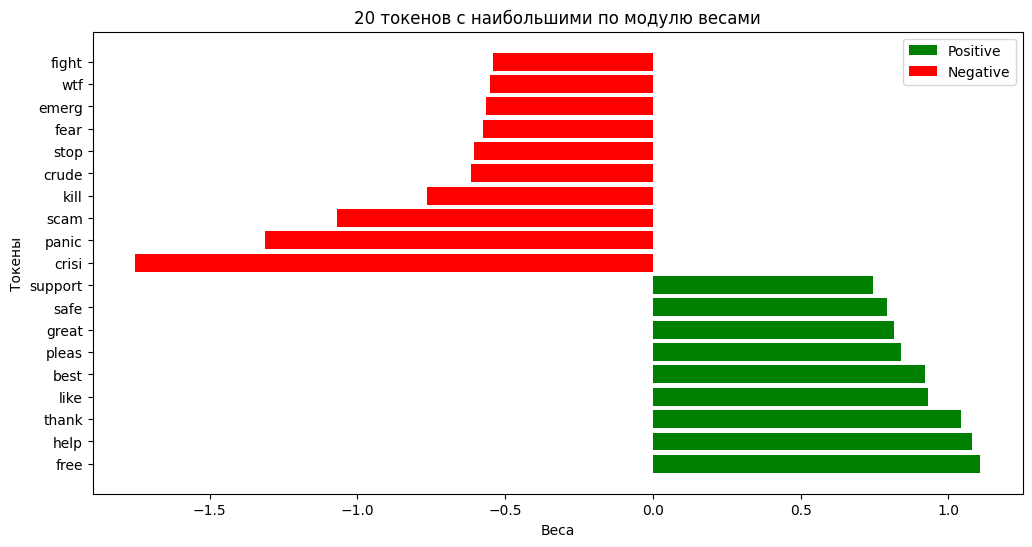

In [ ]:
feature_names = vec_3.get_feature_names_out()

coefs = clf_3.coef_[0]
sort_coefs = np.argsort(coefs)

top_positive_ind = sort_coefs[-10:-1][::-1]
top_negative_ind = sort_coefs[0:10]

top_positive_coefs = coefs[top_positive_ind] # топ-10 положительных коэффициентов
top_negative_coefs = coefs[top_negative_ind] # топ-10 отрицательных коэффициентов
top_positive_features = feature_names[top_positive_ind] # топ-10 позитивных слов
top_negative_features = feature_names[top_negative_ind] # топ-10 негативных слов

plt.figure(figsize=(12, 6))
plt.barh(y = top_positive_features, width = top_positive_coefs, color = 'green', label = 'Positive') # зеленый график для позитивных слов
plt.barh(y = top_negative_features, width = top_negative_coefs, color = 'red', label = 'Negative') # красный график для негативных слов
plt.xlabel('Веса')
plt.ylabel('Токены')
plt.title('20 токенов с наибольшими по модулю весами')
plt.legend()
plt.show()

**Ответ:** После скалирования качество на тренировочной выборке стало выше, а на тестовой - ниже.

Про токены можно сказать, что сами по себе они имеют яркую окраску (например, негативную: panic, kill, scam; позитивную: help, thank, like), поэтому наша модель хорошо справилась с определением весов, и способна на их основе определять эмоциональную окраску твитта.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
print(len(df['UserName'].unique()) == len(df))
print(len(df['ScreenName'].unique()) == len(df))

True
True


**Ответ:** В нашем случае признаки UserName и ScreenName не будут полезными, так как сами по себе они никакой дополнительной информации не несут, а также среди этих признаков нет повторяющихся значений. Если бы у этих признаков были повторяющиеся значения (один человек написал несколько твитов), то можно было бы найти закономерность, что твитты, оставляемые человеком с определенным ником чаще всего имеют положительную или негативную окраску, и это увеличило бы качество нашей модели.



Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

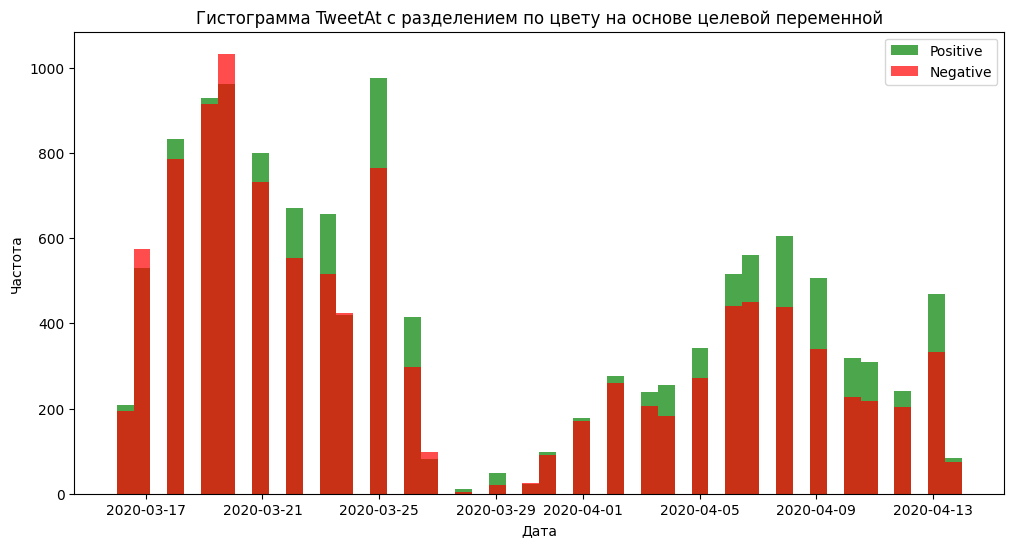

In [ ]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y') # преобразуем к типу datetime признак тренировочной выборки
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format='%d-%m-%Y') # преобразуем к типу datetime признак тестовой выборки

plt.figure(figsize=(12, 6))
plt.hist(train[train['Sentiment'] == 1]['TweetAt'], bins = 50, color = 'green', alpha = 0.7, label = 'Positive') # зеленая гистограмма дат для позитивных твитов
plt.hist(train[train['Sentiment'] == 0]['TweetAt'], bins = 50, color = 'red', alpha = 0.7, label = 'Negative') # красная гистограмма дат для негативных твитов
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.title('Гистограмма TweetAt с разделением по цвету на основе целевой переменной')
plt.legend()
plt.show()

**Ответ:** По гистограмме видно, что на каждом столбике разница между негативными и позитивными твиттами в эти даты несущественная: почти везде позитивных твиттов чуть больше, чем негативных, поэтому даты практически неразличимы между собой. Этот признак мог бы улучшить качество модели, если бы из общей массы выбивались даты, в которых были существенные различия между количеством негативных и позитивных твиттов, например, в тот день вышла какая-нибудь поражающая новость, которую все стали бы обсуждать. Тогда для твиттов в эту дату наша модель была бы склонна давать предикт в соответствии с эмоциональной окраской большинства твиттов, тем самым качество модели бы улучшилось. Но, как уже было сказано, по гистограмме видно, что таких дат нет.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [26]:
print('Количество уникальных значений:', len(train['Location'].unique()))

Количество уникальных значений: 7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

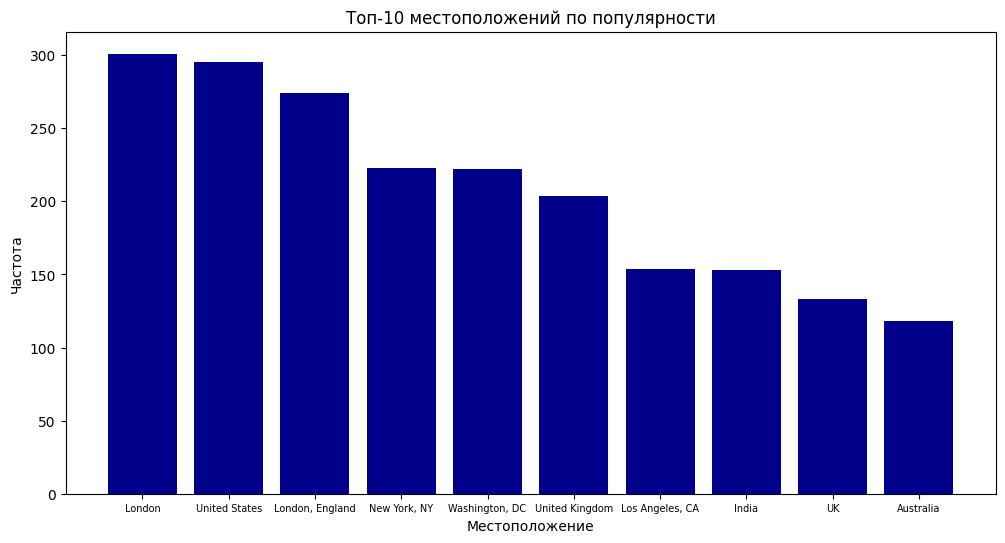

In [27]:
locations = train['Location'].value_counts()


plt.figure(figsize=(12, 6))
plt.bar(locations.index[1:11], locations.values[1:11], color = 'darkblue')
plt.xlabel('Местоположение')
plt.xticks(fontsize=7)
plt.ylabel('Частота')
plt.title('Топ-10 местоположений по популярности')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [28]:
clear_loc = []
for loc in train['Location']:
# берем последнюю часть от местоположения (самое широкое)
  first = loc.split(', ')[-1]
  if first.split(' ')[-1] == '':
    clear_loc.append(first)
  else:
    clear_loc.append(first.split(' ')[-1])
train['WiderLocation'] = clear_loc
print('Количество уникальных значений:', len(train['WiderLocation'].unique()))

Количество уникальных значений: 3476


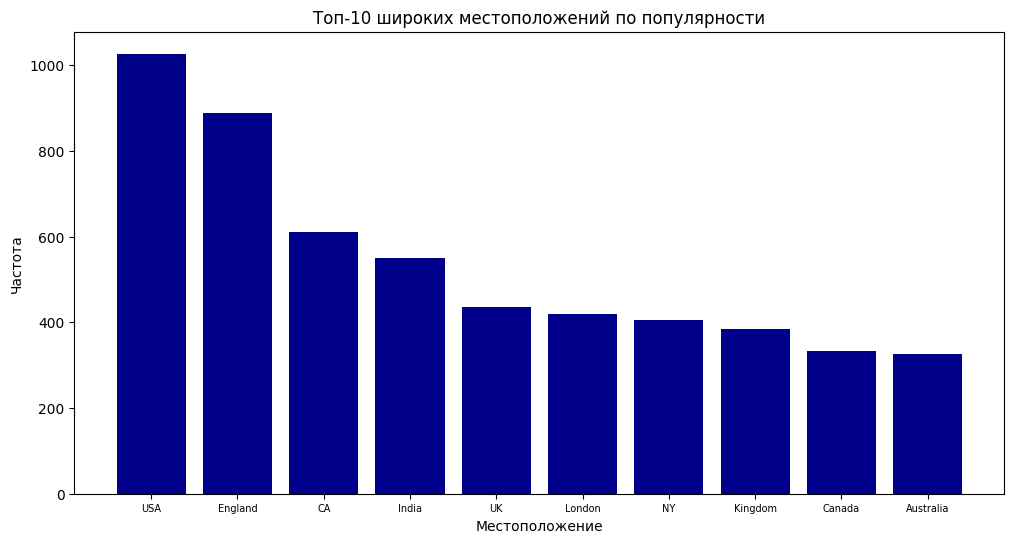

In [29]:
locations = train['WiderLocation'].value_counts()


plt.figure(figsize=(12, 6))
plt.bar(locations.index[1:11], locations.values[1:11], color = 'darkblue')
plt.xlabel('Местоположение')
plt.xticks(fontsize=7)
plt.ylabel('Частота')
plt.title('Топ-10 широких местоположений по популярности')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [30]:
common_locations = locations[locations > 1].index.tolist() # местоположения, которые встречаются более одного раза
common_locations.remove('Unknown')
print('Количество местоположений, которые встречаются более одного раза (кроме Unknown):', len(common_locations))

Количество местоположений, которые встречаются более одного раза (кроме Unknown): 968


In [31]:
# делаем также, как и на train, только теперь на всех данных, так как нам также нужно WiderLocation на test
clear_loc = []
for loc in df['Location']:
# берем последнюю часть от местоположения (самое широкое)
  first = loc.split(', ')[-1]
  if first.split(' ')[-1] == '':
    clear_loc.append(first)
  else:
    clear_loc.append(first.split(' ')[-1])
df['WiderLocation'] = clear_loc

In [32]:
filtered_df = df[df['WiderLocation'].isin(common_locations)]

In [33]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories=[common_locations], sparse=False)
wider_location_encoded = encoder.fit_transform(filtered_df['WiderLocation'].values.reshape(-1, 1))

In [34]:
df_ohe = pd.DataFrame(wider_location_encoded, columns = filtered_df['WiderLocation'].unique()) # преобразуем np array в dataframe

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [37]:
for i in df_ohe.columns:
  df[i] = (df['WiderLocation'] == i) # проводим операцию OHE вручную, зная нужные столбцы

In [38]:
df.drop(columns = 'WiderLocation', inplace = True)

In [39]:
ohe_train, ohe_test = train_test_split(df.iloc[:,6:], test_size=0.3, random_state=0) # делим закодированные значения на train и test

In [ ]:
bow_df = pd.DataFrame(bow_3.toarray(), columns=vec_3.get_feature_names_out())
all_1 = np.concatenate((bow_df, ohe_train), axis=1) # объединяем отскалированные признаки с закодированными значениями (для train)

In [ ]:
bow_test_df = pd.DataFrame(bow_test_3.toarray(), columns=vec_3.get_feature_names_out())
all_2 = np.concatenate((bow_test_df, ohe_test), axis=1) # объединяем отскалированные признаки с закодированными значениями (для test)

In [ ]:
clf_loc = LogisticRegression(max_iter=200, random_state=0)
clf_loc.fit(all_1, y_train)
pred_train_loc = clf_loc.predict(all_1)
pred_test_loc = clf_loc.predict(all_2)
print('Доля правильных ответов на обучающей выборке:', round(accuracy_score(y_train, pred_train_loc), 5))
print('Доля правильных ответов на тестовой выборке:', round(accuracy_score(y_test, pred_test_loc), 5))

Доля правильных ответов на обучающей выборке: 0.94562
Доля правильных ответов на тестовой выборке: 0.84493


**Ответ:** Признак оказался полезным, так как доля правильных ответов на тестовой выборке увеличилась. На тренировочной выборке качество стало ниже, так как модель стала менее переобученной.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [76]:
vec_itog = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=4)
bow_itog = vec_itog.fit_transform(train['OriginalTweet'])
bow_test_itog = vec_itog.transform(test['OriginalTweet'])

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

bag = GradientBoostingClassifier(n_estimators=3500, max_depth=2, learning_rate=0.2, random_state=0)
bag.fit(bow_itog, y_train)

pred_train_itog = bag.predict(bow_itog)
pred_test_itog = bag.predict(bow_test_itog)

print('Доля правильных ответов на обучающей выборке:', round(accuracy_score(y_train, pred_train_itog), 5))
print('Доля правильных ответов на тестовой выборке:', round(accuracy_score(y_test, pred_test_itog), 5))

Доля правильных ответов на обучающей выборке: 0.97087
Доля правильных ответов на тестовой выборке: 0.88758
